In [7]:
fiel_path="https://drive.google.com/file/d/10srb_7Vc1JY38zirs59f5kjBRrNDqTFl/view?usp=drive_link"

## enrgy usage forecasting using prophet

In [1]:
!pip install gdown

In [2]:
import gdown


file_id = '10srb_7Vc1JY38zirs59f5kjBRrNDqTFl'
output_path = 'individual+household+electric+power+consumption.txt'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, fuzzy=True)

# Read the downloaded CSV file into a pandas DataFrame


Downloading...
From: https://drive.google.com/uc?id=10srb_7Vc1JY38zirs59f5kjBRrNDqTFl
To: /content/individual+household+electric+power+consumption.txt
100%|██████████| 20.6M/20.6M [00:00<00:00, 29.3MB/s]


'individual+household+electric+power+consumption.txt'

In [3]:
!unzip individual+household+electric+power+consumption.txt

Archive:  individual+household+electric+power+consumption.txt
  inflating: household_power_consumption.txt  


## load the data

In [4]:
# let's import neccessary data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# 1. READ .txt directly (semicolon-separated)
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',  # Key: semicolon delimiter
                 parse_dates={'datetime': [0,1]},  # Combine Date + Time
                 infer_datetime_format=True,
                 low_memory=False,
                 na_values=['nan','?'])

# 2. SAVE as clean .csv (2 seconds)
df.to_csv('household_power_consumption.csv', index=False)
print("✓ Converted to CSV:", df.shape)  # (2M rows, 9 cols)


/tmp/ipython-input-1840976502.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt',
/tmp/ipython-input-1840976502.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt',
/tmp/ipython-input-1840976502.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt',


✓ Converted to CSV: (2075259, 8)


In [6]:
df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [7]:
# let's dropna if the target column is nan
df.dropna(subset=['Global_active_power'], inplace=True)

In [8]:
df.set_index('datetime', inplace=True)

df_hourly = df.resample('H').agg({
    'Voltage': 'mean',
    'Global_intensity': 'mean',

    # Reactive & Active Power (kW) → convert to kWh
    'Global_active_power': lambda x: x.sum() / 60,
    'Global_reactive_power': lambda x: x.sum() / 60,

    # Sub-metering (Wh energy) → sum directly (do NOT divide)
    'Sub_metering_1': 'sum',
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum'
})

df_hourly = df_hourly.dropna()
print(df_hourly.shape)


/tmp/ipython-input-3621803575.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').agg({


(34168, 7)


In [9]:
df_hourly.head()

,Voltage,Global_intensity,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,234.643889,18.100000,2.533733,0.137400,0.0,19.0,607.0
2006-12-16 18:00:00,234.580167,15.600000,3.632200,0.080033,0.0,403.0,1012.0
2006-12-16 19:00:00,233.232500,14.503333,3.400233,0.085233,0.0,86.0,1001.0
2006-12-16 20:00:00,234.071500,13.916667,3.268567,0.075100,0.0,0.0,1007.0
2006-12-16 21:00:00,237.158667,13.046667,3.056467,0.076667,0.0,25.0,1033.0


In [10]:
df_prophet = df_hourly.reset_index()
df_prophet = df_prophet.rename(columns={'datetime':'ds', 'Global_active_power':'y'})

In [11]:
df_prophet['lag1'] = df_prophet['y'].shift(1)   # previous hour
df_prophet['lag24'] = df_prophet['y'].shift(24) # same hour yesterday
df_prophet['lag168'] = df_prophet['y'].shift(168) # same hour last week

# drop first 168 rows with NaNs
df_prophet = df_prophet.dropna()


let's split our data into train and test data

In [12]:
regressors = ['Voltage', 'Global_intensity', 'Sub_metering_1',
              'Sub_metering_2', 'Sub_metering_3',
              'lag1','lag24','lag168']


In [13]:
train = df_prophet.iloc[:-168]  # last week = test
test = df_prophet.iloc[-168:]

y_test = test['y']
test_dates = test['ds']


In [14]:
from prophet import Prophet

m = Prophet(daily_seasonality=True, weekly_seasonality=True,
            changepoint_prior_scale=0.5,
            seasonality_prior_scale=10,
            seasonality_mode="multiplicative")

for r in regressors:
    m.add_regressor(r)

m.fit(train[['ds','y'] + regressors])


In [15]:
future = m.make_future_dataframe(periods=168, freq='H')

# --- Copy historical regressors for the history part ---
for r in ['Voltage', 'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3',
          'lag1','lag24','lag168']:
    future[r] = np.nan  # initialize

# Fill historical part (matches train)
future.loc[:len(df_prophet)-1, ['Voltage', 'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']] = \
    df_prophet[['Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']].values

future.loc[:len(df_prophet)-1, ['lag1','lag24','lag168']] = \
    df_prophet[['lag1','lag24','lag168']].values

# --- Fill only future horizon (last 168 rows) ---
future.loc[len(df_prophet):, ['Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']] = \
    df_prophet[['Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']].iloc[-168:].values

# For lag features in future, use last known values or rolling pattern
future.loc[len(df_prophet):, ['lag1','lag24','lag168']] = \
    df_prophet[['lag1','lag24','lag168']].iloc[-168:].values


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [16]:
forecast = m.predict(future)

# Extract only test period
fc = forecast.set_index('ds')
prophet_pred = fc.loc[test_dates]['yhat']

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rmse = np.sqrt(mean_squared_error(y_test, prophet_pred))
mape = mean_absolute_percentage_error(y_test, prophet_pred)*100

print("Prophet RMSE:", rmse)
print("Prophet MAPE:", mape)


Prophet RMSE: 0.06946584099959471
Prophet MAPE: 12.214427187505184


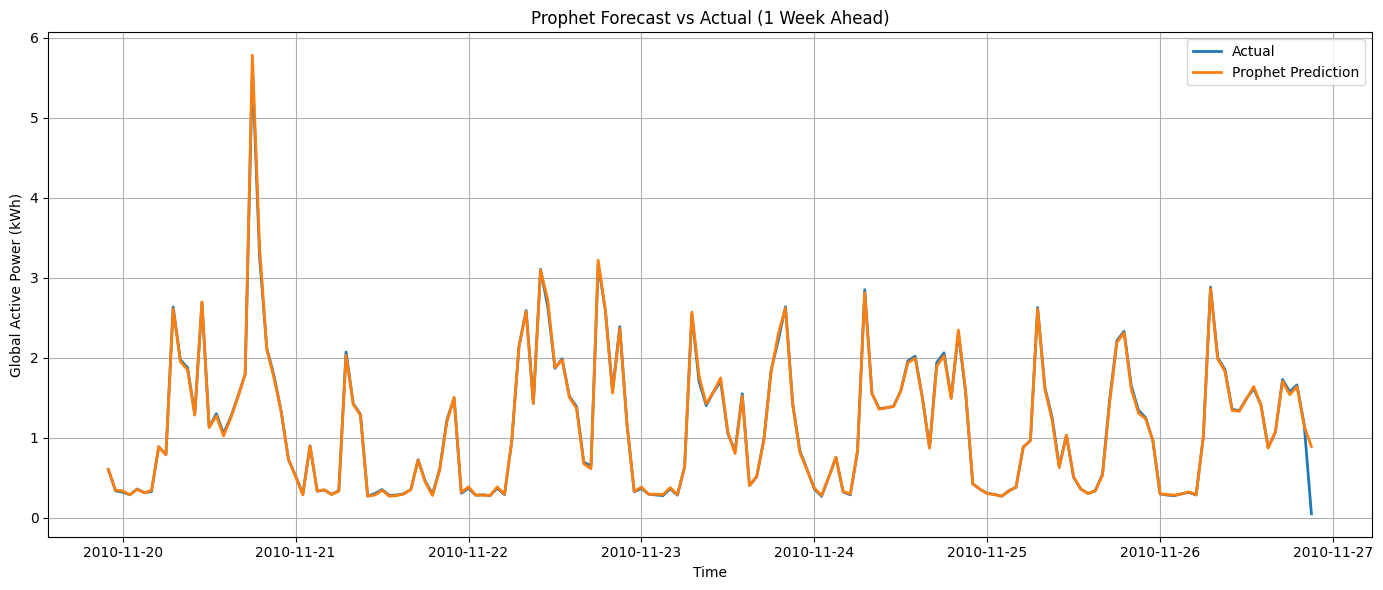

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(test_dates, y_test, label='Actual', linewidth=2)
plt.plot(test_dates, prophet_pred, label='Prophet Prediction', linewidth=2)
plt.title("Prophet Forecast vs Actual (1 Week Ahead)")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('prophet-forecast vs actula.png')
plt.show()
